## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

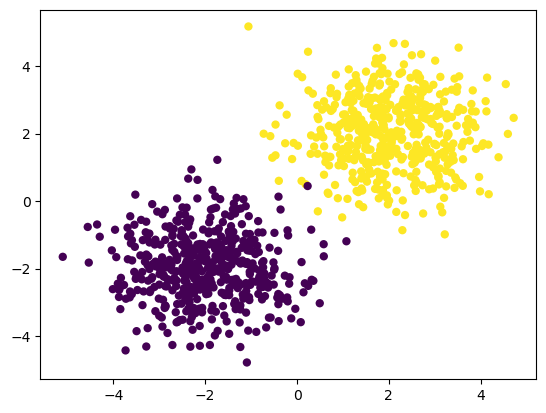

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

# print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 75

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

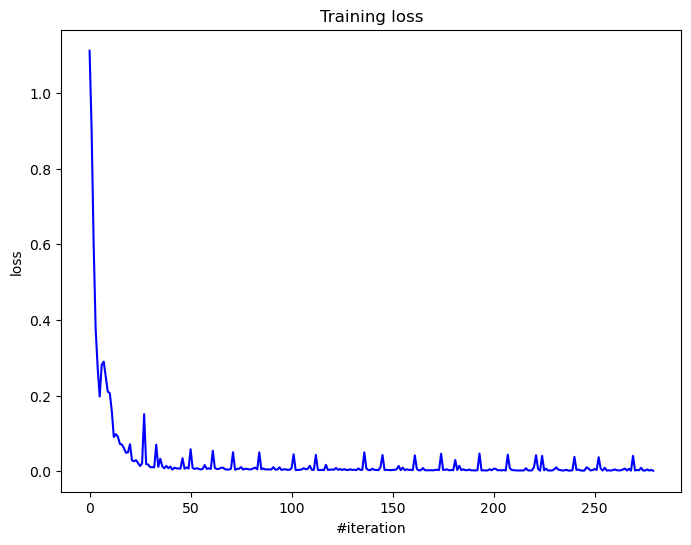

Current loss: 0.001553


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 28, 28)
(50000,)
(10000, 28, 28)
(10000,)
(10000, 28, 28)
(10000,)


In [10]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
from sklearn.preprocessing import OneHotEncoder


One-hot encode the labels first.

In [12]:
# Your code goes here. ################################################
encoder = OneHotEncoder(sparse_output=False)
y_train_encod = encoder.fit_transform(y_train.reshape(-1, 1))
print(encoder.categories_)
print(y_train_encod.shape)


[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]
(50000, 10)


In [13]:
def get_batches(X_train, y_train, batch_size):
    X, Y = X_train, y_train
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [14]:
def train(net, X, y, batch_size, n_epoch, criterion, optimizer, optimizer_config, optimizer_state):
    loss_history = []
    net.train()
    for i in range(n_epoch):
        for X_batch, y_batch in get_batches(X, y, batch_size):
            net.zeroGradParameters()
            
            predict = net.forward(X_batch)
            loss = criterion.forward(predict, y_batch)
            
            dp = criterion.backward(predict, y_batch)
            net.backward(X_batch, dp)
            
            optimizer(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)
            
            loss_history.append(loss)
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()
    
        print('Current loss: %f' % loss)
    return loss_history

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [15]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 250

#ReLU
net_relu = Sequential()
net_relu.add(Flatten())
net_relu.add(Linear(784, 7))
net_relu.add(ReLU())
net_relu.add(Linear(7, 10))
net_relu.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net_relu)

Flatten
Linear 784 -> 7
ReLU
Linear 7 -> 10
LogSoftMax



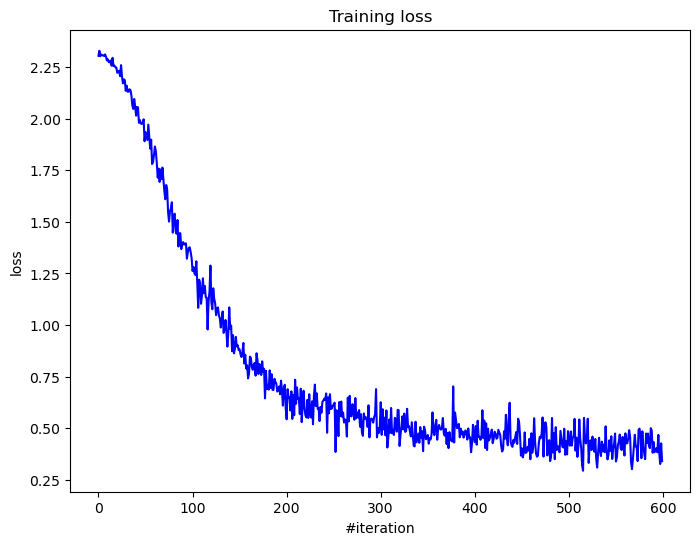

Current loss: 0.341112
CPU times: user 5min 4s, sys: 6.62 s, total: 5min 11s
Wall time: 3min 14s


In [16]:
%%time
net_relu_loss_history = train(net_relu, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, sgd_momentum, 
                              optimizer_config, optimizer_state)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [17]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 250

#ELU
net_elu = Sequential()
net_elu.add(Flatten())
net_elu.add(Linear(784, 7))
net_elu.add(ELU())
net_elu.add(Linear(7, 10))
net_elu.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net_elu)

Flatten
Linear 784 -> 7
ELU
Linear 7 -> 10
LogSoftMax



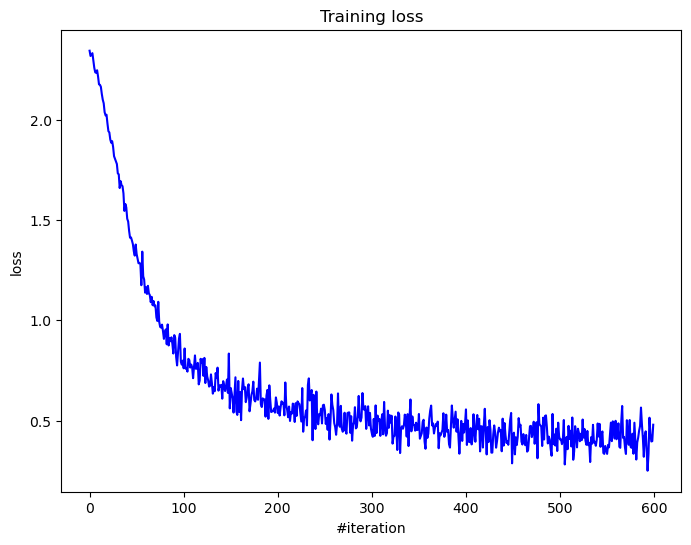

Current loss: 0.479294
CPU times: user 4min 53s, sys: 6.65 s, total: 5min
Wall time: 3min 2s


In [18]:
%%time
net_elu_loss_history = train(net_elu, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, sgd_momentum, 
                              optimizer_config, optimizer_state)

In [19]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 250

#LeakyReLU
net_leakyrelu = Sequential()
net_leakyrelu.add(Flatten())
net_leakyrelu.add(Linear(784, 7))
net_leakyrelu.add(LeakyReLU())
net_leakyrelu.add(Linear(7, 10))
net_leakyrelu.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net_leakyrelu)

Flatten
Linear 784 -> 7
LeakyReLU
Linear 7 -> 10
LogSoftMax



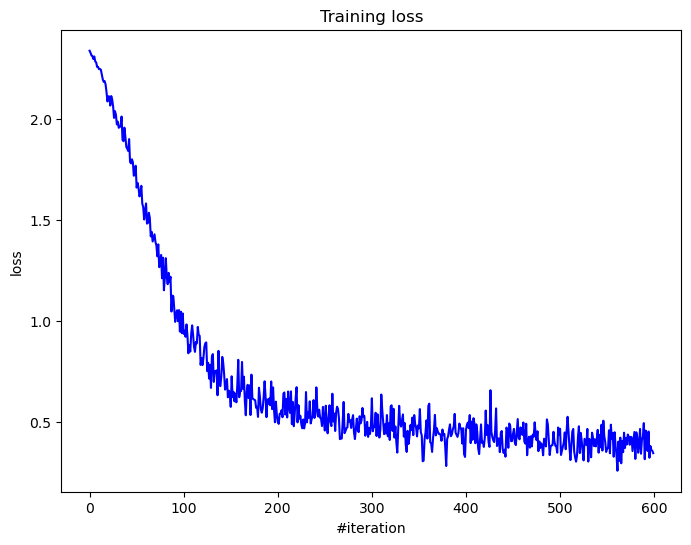

Current loss: 0.345489
CPU times: user 4min 54s, sys: 6.77 s, total: 5min 1s
Wall time: 3min 3s


In [20]:
%%time
net_leakyrelu_loss_history = train(net_leakyrelu, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, sgd_momentum, 
                              optimizer_config, optimizer_state)

In [21]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 250

#SoftPlus
net_softplus = Sequential()
net_softplus.add(Flatten())
net_softplus.add(Linear(784, 7))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(7, 10))
net_softplus.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net_softplus)

Flatten
Linear 784 -> 7
SoftPlus
Linear 7 -> 10
LogSoftMax



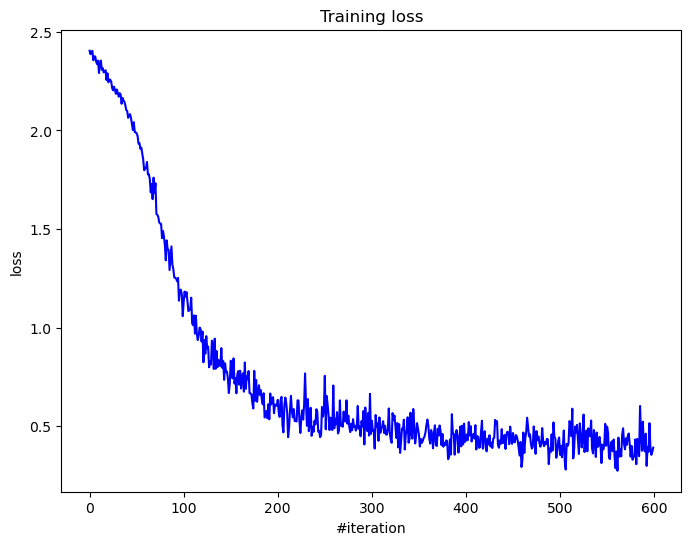

Current loss: 0.391968
CPU times: user 4min 53s, sys: 6.3 s, total: 5min
Wall time: 3min 2s


In [22]:
%%time
net_softplus_loss_history = train(net_softplus, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, sgd_momentum, 
                              optimizer_config, optimizer_state)

In [23]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 3
batch_size = 250

#BatchNorm
net_batchnorm = Sequential()
net_batchnorm.add(Flatten())
net_batchnorm.add(Linear(784, 7))
net_batchnorm.add(BatchNormalization(alpha=0.9))
net_batchnorm.add(ChannelwiseScaling(7))
net_batchnorm.add(ReLU())
net_batchnorm.add(Linear(7, 10))
net_batchnorm.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net_batchnorm)

Flatten
Linear 784 -> 7
BatchNormalization
ChannelwiseScaling
ReLU
Linear 7 -> 10
LogSoftMax



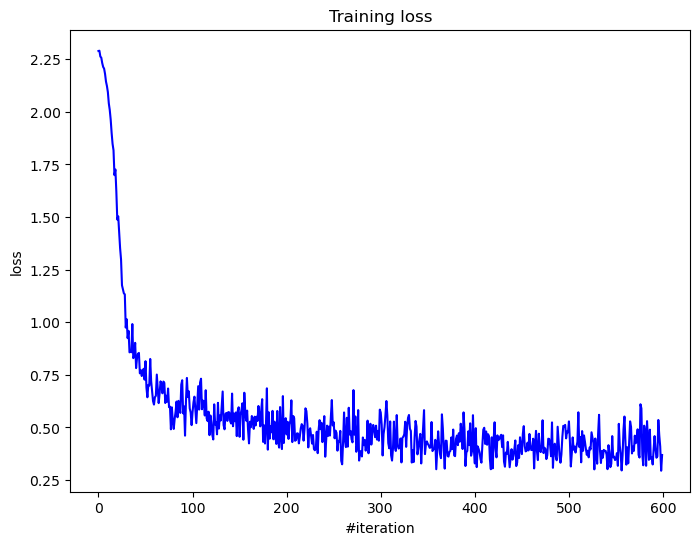

Current loss: 0.368777
CPU times: user 5min, sys: 6.66 s, total: 5min 7s
Wall time: 3min 9s


In [24]:
%%time
net_batchnorm_loss_history = train(net_batchnorm, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, sgd_momentum, 
                              optimizer_config, optimizer_state)

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

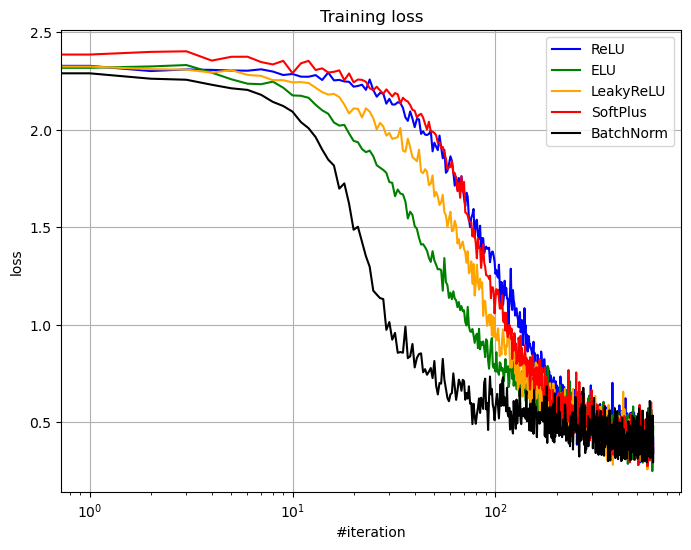

In [25]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.semilogx(net_relu_loss_history,  color='blue', label='ReLU')
plt.semilogx(net_elu_loss_history,  color='green', label='ELU')
plt.semilogx(net_leakyrelu_loss_history,  color='orange', label='LeakyReLU')
plt.semilogx(net_softplus_loss_history,  color='red', label='SoftPlus')
plt.semilogx(net_batchnorm_loss_history,  color='black', label='BatchNorm')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
optimizer_config_momentum = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state_momentum = {}
optimizer_config_adam = {'learning_rate' : 1e-1, 'beta1': 0.9, 'beta2':0.99, 'epsilon':1e-8}
optimizer_state_adam = {}
# Looping params
n_epoch = 3
batch_size = 250

#Momentum
net_momentum = Sequential()
net_momentum.add(Flatten())
net_momentum.add(Linear(784, 7))
net_momentum.add(BatchNormalization(alpha=0.9))
net_momentum.add(ChannelwiseScaling(7))
net_momentum.add(ReLU())
net_momentum.add(Linear(7, 10))
net_momentum.add(LogSoftMax())

#Adam
net_adam = Sequential()
net_adam.add(Flatten())
net_adam.add(Linear(784, 7))
net_adam.add(BatchNormalization(alpha=0.9))
net_adam.add(ChannelwiseScaling(7))
net_adam.add(ReLU())
net_adam.add(Linear(7, 10))
net_adam.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net_momentum)
print(net_adam)

Flatten
Linear 784 -> 7
BatchNormalization
ChannelwiseScaling
ReLU
Linear 7 -> 10
LogSoftMax

Flatten
Linear 784 -> 7
BatchNormalization
ChannelwiseScaling
ReLU
Linear 7 -> 10
LogSoftMax



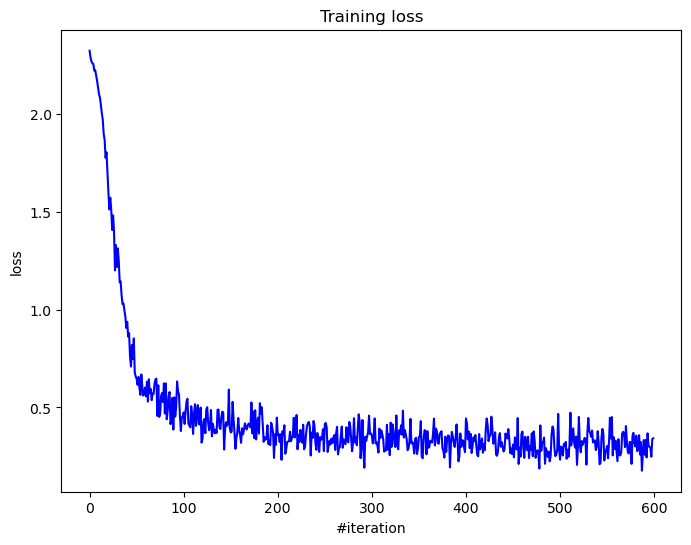

Current loss: 0.342520
CPU times: user 5min 7s, sys: 6.25 s, total: 5min 14s
Wall time: 3min 16s


In [30]:
%%time
net_momentum_loss_history = train(net_momentum, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, sgd_momentum, 
                              optimizer_config_momentum, optimizer_state_momentum)

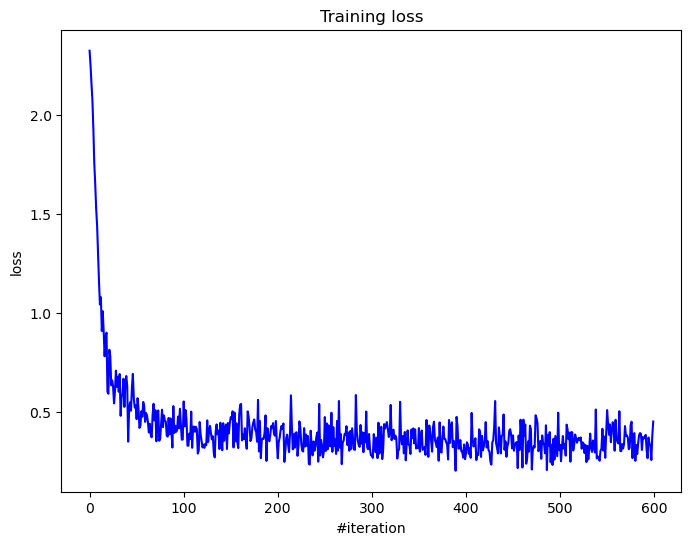

Current loss: 0.451862
CPU times: user 5min 11s, sys: 6.66 s, total: 5min 17s
Wall time: 3min 19s


In [31]:
%%time
net_adam_loss_history = train(net_adam, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, adam_optimizer, 
                              optimizer_config_adam, optimizer_state_adam)

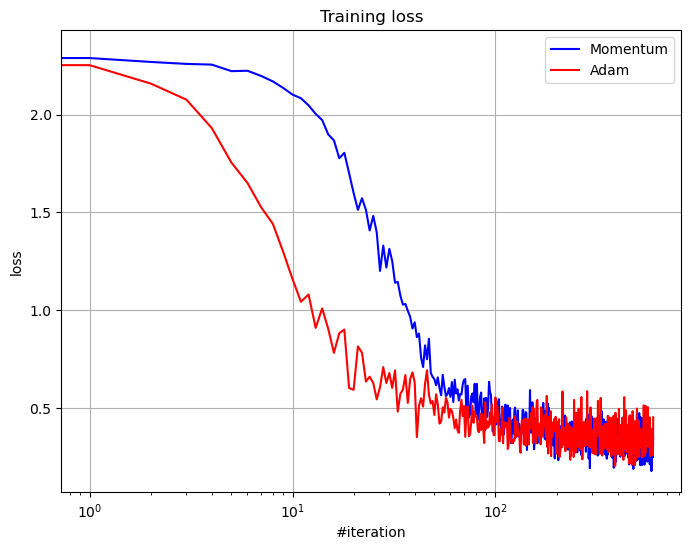

In [32]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.semilogx(net_momentum_loss_history,  color='blue', label='Momentum')
plt.semilogx(net_adam_loss_history,  color='red', label='Adam')
plt.legend()
plt.grid(True)
plt.show()

Print here your accuracy on test set. It should be around 90%.

In [77]:
from sklearn.metrics import accuracy_score

In [78]:
optimizer_config_best = {'learning_rate' : 1e-1, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
optimizer_state_best = {}
# Looping params
n_epoch = 10
batch_size = 500

#Adam
net_best = Sequential()
net_best.add(Flatten())
net_best.add(Linear(784, 10))
net_best.add(BatchNormalization(alpha=0.9))
net_best.add(ChannelwiseScaling(10))
net_best.add(Dropout(p=0.2))
net_best.add(ReLU())
net_best.add(Linear(10, 10))
net_best.add(BatchNormalization(alpha=0.9))
net_best.add(ChannelwiseScaling(10))
net_best.add(ReLU())
#net_best.add(Dropout())
net_best.add(Linear(10, 10))
net_best.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net_best)

Flatten
Linear 784 -> 10
BatchNormalization
ChannelwiseScaling
Dropout
ReLU
Linear 10 -> 10
BatchNormalization
ChannelwiseScaling
ReLU
Linear 10 -> 10
LogSoftMax



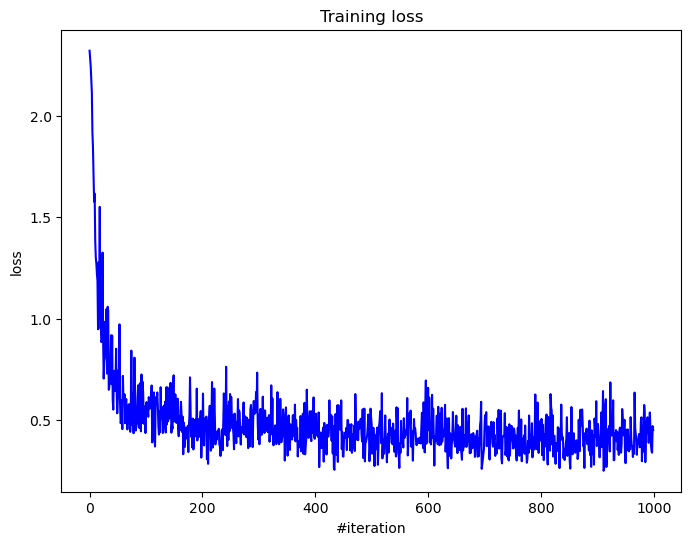

Current loss: 0.452309
CPU times: user 12min 43s, sys: 11.1 s, total: 12min 54s
Wall time: 9min 33s


In [79]:
%%time
net_best_loss_history = train(net_best, X_train, y_train_encod, batch_size, 
                              n_epoch, criterion, adam_optimizer, 
                              optimizer_config_best, optimizer_state_best)

In [80]:
net_best.evaluate()
predict = np.argmax(net_best.forward(X_test), axis=1)
score = accuracy_score(y_test, predict)
print(f'Score: {score}')


Score: 0.896


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [124]:
import torch
from torch import nn

In [125]:
model = nn.Sequential(
          nn.Flatten(),
          nn.Linear(784, 10),
          nn.BatchNorm1d(10, eps=1e-2, momentum=1.-0.9, affine=True),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.Linear(10, 10),
          nn.BatchNorm1d(10, eps=1e-2, momentum=1.-0.9, affine=True),
          nn.ReLU(),
          nn.Linear(10, 10),
          nn.LogSoftmax()
        )

In [126]:
loss_fn = nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, betas=(0.9, 0.999), eps=1e-0)
n_epoch = 10
batch_size = 500

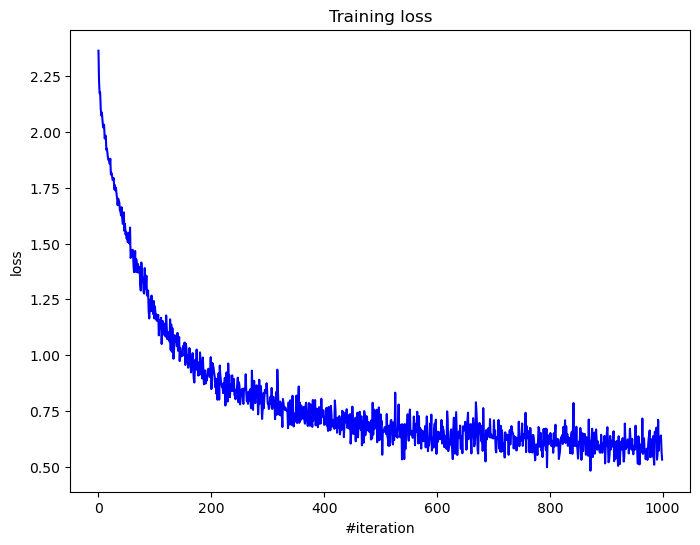

Current loss: 0.531039
CPU times: user 14.3 s, sys: 512 ms, total: 14.8 s
Wall time: 7.97 s


In [127]:
%%time
loss_history_torch = []
model.train()
for i in range(n_epoch):
    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        X_batch = torch.tensor(X_batch)
        y_batch = torch.tensor(y_batch)
            
        predict = model(X_batch)
        #print(predict.shape)
        #print(y_batch.shape)
        loss = loss_fn(predict, y_batch)
        loss_history_torch.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_torch, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [129]:
X_ttest = torch.tensor(X_test)
y_ttest = torch.tensor(y_test)

In [130]:
model.eval()
predict = model(X_ttest)
predict = np.argmax(predict.detach().numpy(), axis=1)
score = accuracy_score(y_test, predict)
print(f'Score: {score}')

Score: 0.9046


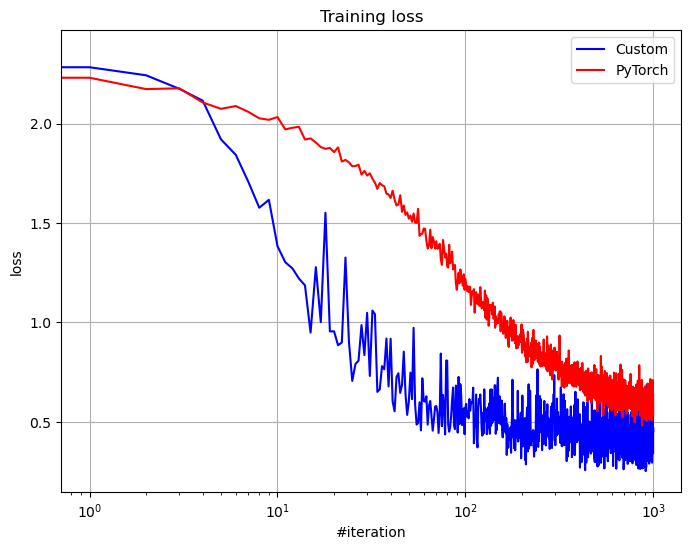

In [131]:
plt.figure(figsize=(8, 6))
        
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.semilogx(net_best_loss_history,  color='blue', label='Custom')
plt.semilogx(loss_history_torch,  color='red', label='PyTorch')
plt.legend()
plt.grid(True)
plt.show()